In [86]:
import numpy as np
# from submit import my_fit
import time as tm
from sklearn.metrics import mean_absolute_error as mae

from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
import matplotlib.pyplot as plt


In [87]:
X_trn = np.loadtxt("train_challenges.dat")
y_trn = np.loadtxt("train_responses.dat")
X_tst = np.loadtxt("dummy_test_challenges.dat")
y_tst = np.loadtxt("dummy_test_responses.dat")
w_gold = np.loadtxt("weights.dat")

In [88]:
# Hard Thresholding operation
# Given a vector and a sparsity level, sparsify the vector
# by setting small magnitude coordinates to 0
def HT( v, k ):
    t = np.zeros_like( v )
    if k < 1:
        return t
    else:
        ind = np.argsort( abs( v ) )[ -k: ]
        t[ ind ] = v[ ind ]
        return t

In [89]:
def supp_int( x, y, k ):
    x_t = HT( x, k )
    y_t = HT( y, k )
    supp_x = np.where( x_t != 0, 1, 0 )
    supp_y = np.where( y_t != 0, 1, 0 )
    return np.dot( supp_x, supp_y ) / k

In [90]:
n_trials = 5
S = 512

In [91]:
train_size = int(0.8 * X_trn.shape[0])  # 80% for training
X_train = X_trn[:train_size]
y_train = y_trn[:train_size]
X_test = X_trn[train_size:]
y_test = y_trn[train_size:]

def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0.)

def fista(A, b):
    l = 1
    maxit = 16
    x = np.linalg.lstsq( A, b, rcond = None )[0]
    for popop in range(maxit):
      pobj = []
      t = 1
      z = x.copy()
      L = np.linalg.norm(A) ** 2
      for _ in range(popop*maxit):
          xold = x.copy()
          z = z + A.T.dot(b - A.dot(z)) / L
          x = soft_thresh(z, l / L)
          t0 = t
          t = (1. + sqrt(1. + 4. * t ** 2)) / 2.
          z = x + ((t0 - 1.) / t) * (x - xold)
      
      w_opt = HT(x, S)
      non_zero_indices = np.nonzero(w_opt)[0]
      X_train_selected = A[:, non_zero_indices]
      iw = np.linalg.lstsq( X_train_selected, b, rcond = None )[0]
      w_opt[non_zero_indices] = iw
      x=w_opt

    return x

1.0207303722967556e-08


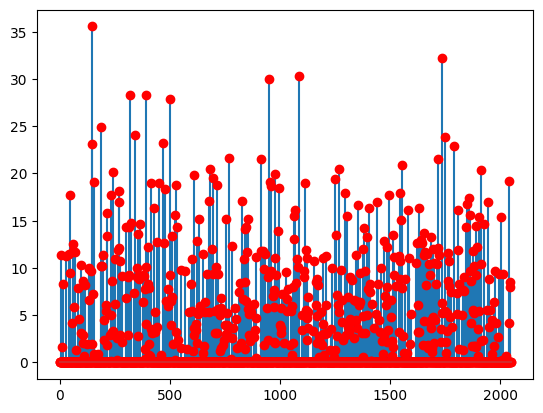

In [92]:
w_fista = fista(X_train, y_train)
prediction = X_test @ w_fista
prediction = np.round_(prediction, decimals = 6)

print(100 * mean_absolute_percentage_error(y_test, prediction))

plt.figure()
plt.stem(w_fista, markerfmt='ro')
plt.show()

In [93]:
train_size = int(0.8 * X_trn.shape[0])  # 80% for training
X_train = X_trn[:train_size]
y_train = y_trn[:train_size]
X_test = X_trn[train_size:]
y_test = y_trn[train_size:]

def HT( v, k ):
    t = np.zeros_like( v )
    ind = np.argsort(abs(v))[ -k: ]
    t[ ind ] = v[ ind ]
    return t

def coordinate_descent(A, b):
    l = 250
    max_iterations = 9
    x = np.linalg.lstsq(A, b, rcond=None)[0]
    n_features = A.shape[1]

    for iter in range(max_iterations):
        for j in range(n_features):
            Aj = A[:, j]
            x_without_j = np.delete(x, j)
            Aj_without_j = np.delete(A, j, axis=1)

            r = b - Aj_without_j.dot(x_without_j)
            c = Aj.T.dot(r)
            x[j] = np.sign(c) * np.maximum(np.abs(c) - l, 0.)/ np.linalg.norm(Aj)**2

        for j in range(n_features):
            Aj = A[:, j]
            x_without_j = np.delete(x, j)
            Aj_without_j = np.delete(A, j, axis=1)
            r = b - Aj_without_j.dot(x_without_j)
            c = Aj.T.dot(r)
            x[j] = np.sign(c) * np.maximum(np.abs(c) - l, 0.)/ np.linalg.norm(Aj)**2

        w_opt = HT(x, S)
        non_zero_indices = np.nonzero(w_opt)[0]
        X_train_selected = A[:, non_zero_indices]
        iw = np.linalg.lstsq( X_train_selected, b, rcond = None )[0]
        w_opt[non_zero_indices] = iw
        x=w_opt

    return x

0.012488912440129847


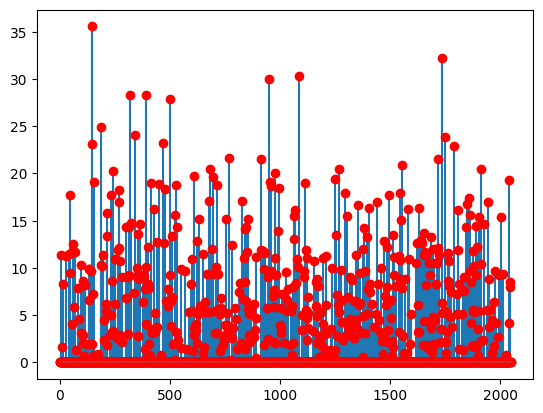

In [94]:
w_cd = coordinate_descent(X_train, y_train)
predictions = X_test @ w_cd
# predictions = np.round_(predictions, decimals=6)   ---- Additional thing to work on

mape = 100 * mean_absolute_percentage_error(y_test, predictions)
print(mape)

plt.figure()
plt.stem(w_cd, markerfmt='ro')
plt.show()

10.465253364585198
-------------linalgs-------------
1.1255477399931328
-------------linalgend-------------
1.6871188108849335
1.4909875116370157
-------------linalgs-------------
0.8988817587288787
-------------linalgend-------------
1.3719704787869231
1.2630114822499556
-------------linalgs-------------
0.8818488393882329
-------------linalgend-------------
1.1777203493467703
1.1151327664033786
-------------linalgs-------------
0.8666469385746004
-------------linalgend-------------
1.06049220403437
1.0038789914910136
-------------linalgs-------------
0.8175627376725013
-------------linalgend-------------
0.9542286508766327
0.9214580317215001
-------------linalgs-------------
0.7408370645471384
-------------linalgend-------------
0.8855099143587342
0.8478498338889766
-------------linalgs-------------
0.7016182470340452
-------------linalgend-------------
0.8203092388942889
0.7976699495965045
-------------linalgs-------------
0.703377579095123
-------------linalgend-------------
0.7787

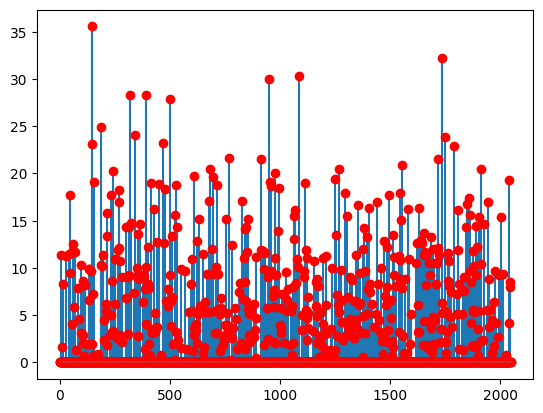

In [102]:
train_size = int(0.9 * X_trn.shape[0])  # 80% for training
X_train = X_trn[:train_size]
y_train = y_trn[:train_size]
X_test = X_trn[train_size:]
y_test = y_trn[train_size:]


def gradient(w, X, y):
    n = X.shape[0]
    return (1/n) * X.T.dot(X.dot(w) - y)


def proximal_operator(w, gamma):
    return np.sign(w) * np.maximum(np.abs(w) - gamma, 0)


def HT(v, k):
    t = np.zeros_like(v)
    if k < 1:
        return t
    else:
        ind = np.argsort(abs(v))[-k:]
        t[ind] = v[ind]
        return t


def gradient_descent(X, y):
    n, d = X.shape
    eta = 0.0016
    w = np.array(np.linalg.lstsq(X, y, rcond=None)[0])
    t = 0
    max_iter = 40000

    for t in range(max_iter):
        gradient_w = gradient(w, X, y)
        z = w - (eta * gradient_w)
        gradient_w = gradient(z, X, y)
        w = z - (eta * gradient_w)
        w_next = HT(w, S)
        w = w_next
        if(t%2000==1000):
          w_tmp=w.copy()
          non_zero_indices = np.nonzero(w_tmp)[0]
          X_train_selected = X_train[:, non_zero_indices]
          iw = np.linalg.lstsq( X_train_selected, y_train, rcond = None )[0]
          w_tmp[non_zero_indices] = iw
          print("-------------linalgs-------------")
          predictions = X_test @ w_tmp
          mape = 100 * mean_absolute_percentage_error(y_test, predictions)
          print(mape)
          print("-------------linalgend-------------")

        if(t%1000==2):
          predictions = X_test @ w
          mape = 100 * mean_absolute_percentage_error(y_test, predictions)
          print(mape)

    return w

w_gd = gradient_descent(X_train, y_train)

predictions = X_test @ w_gd
# predictions = np.round_(predictions, decimals=6)   ---- Additional thing to work on
mape = 100 * mean_absolute_percentage_error(y_test, predictions)
print(mape)

non_zero_indices = np.nonzero(w_gd)[0]
X_train_selected = X_train[:, non_zero_indices]
iw = np.linalg.lstsq( X_train_selected, y_train, rcond = None )[0]
w_gd[non_zero_indices] = iw

predictions = X_test @ w_gd
# predictions = np.round_(predictions, decimals=6)   ---- Additional thing to work on
mape = 100 * mean_absolute_percentage_error(y_test, predictions)
print(mape)

plt.figure()
plt.stem(w_cd, markerfmt='ro')
plt.show()


Jzz for reference stuff..
```
11.52582982779666
1.8180006104718351
1.6900839016710436
1.5766428370793764
1.4916742901394087
1.4295392802271776
1.3725942765581998
1.316133370165842
1.2635172873772238
1.21727523325414
1.1780319857754995
0.8818488393882329
```

```
10.465253364585198
1.6871188108849335
1.4909875116370157
1.3719704787869231
1.2630114822499556
1.1777203493467703
1.1151327664033786
1.06049220403437
1.0038789914910136
0.9542286508766327
0.9214580317215001
0.8855099143587342
0.8478498338889766
0.8203092388942889
0.7976699495965045
0.7787647381919024
0.7626503190171806
0.7441472248281544
0.7286532875973293
0.7129887599456266
0.6848436821727255
0.6525312604369097
0.6206019884803851
0.5902320835644915
0.5640446131248397
0.5437768353735891
0.5272741766262955
0.5100224963610445
0.48753390890031256
0.47112299417932935
0.4555259670966631
0.4442346052657138
0.43546375723836417
0.42826618714115144
0.4230404531140467
0.41328306379987995
0.4076348872470525
0.40385205195016566
0.393541952225696
0.3808717118591609
0.37464042063709385
0.36181635940195717
```

In [103]:
predictions = X_trn @ w_gd
# predictions = np.round_(predictions, decimals=6)   ---- Additional thing to work on
mape = 100 * mean_absolute_percentage_error(y_trn, predictions)
print(mape)

0.24101254661297317


In [104]:
t_train = 0
model_err = 0
mae_err = 0
supp_rec = 0

for t in range( n_trials ):
  tic = tm.perf_counter()
  # w_hat = HT( gradient_descent( X_trn, y_trn ), S )
  w_hat=w_gd
  toc = tm.perf_counter()
  t_train += toc - tic
  model_err += np.linalg.norm( w_hat - w_gold )
  mae_err += mae( y_tst,  X_tst @ w_hat )
  supp_rec += supp_int( w_hat, w_gold, S )

t_train /= n_trials
model_err /= n_trials
mae_err /= n_trials
supp_rec /= n_trials

print( t_train, model_err, mae_err, supp_rec )

t_train = 0
model_err = 0
mae_err = 0
supp_rec = 0

for t in range( n_trials ):
  tic = tm.perf_counter()
  # w_hat = HT( coordinate_descent( X_trn, y_trn ), S )
  w_hat = w_cd
  toc = tm.perf_counter()
  t_train += toc - tic
  model_err += np.linalg.norm( w_hat - w_gold )
  mae_err += mae( y_tst,  X_tst @ w_hat )
  supp_rec += supp_int( w_hat, w_gold, S )

t_train /= n_trials
model_err /= n_trials
mae_err /= n_trials
supp_rec /= n_trials

print( t_train, model_err, mae_err, supp_rec )

t_train = 0
model_err = 0
mae_err = 0
supp_rec = 0

for t in range( n_trials ):
  tic = tm.perf_counter()
  w_hat = HT( fista( X_trn, y_trn ), S )
  toc = tm.perf_counter()
  t_train += toc - tic
  model_err += np.linalg.norm( w_hat - w_gold )
  mae_err += mae( y_tst,  X_tst @ w_hat )
  supp_rec += supp_int( w_hat, w_gold, S )

t_train /= n_trials
model_err /= n_trials
mae_err /= n_trials
supp_rec /= n_trials

print( t_train, model_err, mae_err, supp_rec )

1.7199998183059507e-06 17.366512003202743 4.992845887435969 0.8671875
7.643999197171069e-07 18.94980492157666 0.17846296735395437 0.8359375
10.955540057600047 18.95756853975563 1.945045103184384e-07 0.833984375


In [ ]:
# for t in range( n_trials ):
#   tic = tm.perf_counter()
#   w_hat = HT( my_fit( X_trn, y_trn ), S )
#   toc = tm.perf_counter()
#   t_train += toc - tic
#   model_err += np.linalg.norm( w_hat - w_gold )
#   mae_err += mae( y_tst,  X_tst @ w_hat )
#   supp_rec += supp_int( w_hat, w_gold, S )

In [ ]:
# t_train /= n_trials
# model_err /= n_trials
# mae_err /= n_trials
# supp_rec /= n_trials

# print( t_train, model_err, mae_err, supp_rec )

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_trn, y_trn, test_size=0.2, random_state=10)

# train_size = int(0.8 * X_trn.shape[0])  # 80% for training
# X_train = X_trn[:train_size]
# y_train = y_trn[:train_size]
# X_test = X_trn[train_size:]
# y_test = y_trn[train_size:]



# def rho_compute(y,X,w,j):
#     X_k = np.delete(X,j,1)
#     w_k = np.delete(w,j)
#     predict_k = np.matmul(X_k, w_k)
#     residual = y - predict_k
#     rho_j = np.sum(X[:,j]*residual)
#     return(rho_j)

# def z_compute(X):
#     z_vector = np.sum(X*X, axis = 0)
#     return(z_vector)

# def coordinate_descent(y,X,w,alpha,z,tolerance):
#     max_step = 100.
#     iteration = 0
#     while(max_step > tolerance):
#         iteration += 1
#         old_weights = np.copy(w)
#         for j in range(len(w)):
#             rho_j = rho_compute(y,X,w,j)
#             if j == 0:
#                 w[j] = rho_j/z[j]
#             elif rho_j < -alpha*len(y):
#                 w[j] = (rho_j + (alpha*len(y)))/z[j]
#             elif rho_j > -alpha*len(y) and rho_j < alpha*len(y):
#                 w[j] = 0.
#             elif rho_j > alpha*len(y):
#                 w[j] = (rho_j - (alpha*len(y)))/z[j]
#             else:
#                 w[j] = np.NaN
#         #print("\nNew Weights\n",w)
#         step_sizes = abs(old_weights - w)
#         print("\nStep sizes\n",step_sizes)
#         max_step = step_sizes.max()
#         print("\nMax step:",max_step)
        
        
#     return(w, iteration, max_step)

# w = np.zeros(X_train.shape[1], dtype = float)
# alpha = 0.01
# tolerance = 1
# w_opt, iterations, max_step = coordinate_descent(y_train,X_train,w,alpha,z,tolerance)

# w_opt = HT(w_opt, S)
# non_zero_indices = np.nonzero(w_opt)[0]
# X_train_selected = X_train[:, non_zero_indices]

# iw = np.linalg.lstsq( X_train_selected, y_train, rcond = None )[0]
# w_opt[non_zero_indices] = iw

# prediction = X_test @ w_opt
# print(100 * mean_absolute_percentage_error(y_test, prediction))

In [ ]:
# selected_columns = np.nonzero(weights)[0]
# X_train_selected = X_train[:, selected_columns]
# nw = my_fit(X_train_selected, y_train)
# weights[selected_columns] = nw

# print(weights.shape)

# prediction = X_test @ weights
# print(100 * mean_absolute_percentage_error(y_test, prediction))


In [ ]:
# # Implementation 2
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_trn, y_trn, test_size=0.2, random_state=10)

# def gradient(w, X, y):
#     n = X.shape[0]
#     return (1/n) * X.T.dot(X.dot(w) - y)

# def proximal_operator(w, gamma):
#     return np.sign(w) * np.maximum(np.abs(w) - gamma, 0)

# def HT(v, k):
#     t = np.zeros_like(v)
#     if k < 1:
#         return t
#     else:
#         ind = np.argsort(abs(v))[-k:]
#         t[ind] = v[ind]
#         return t

# def my_fit( X_trn, y_trn,alp ):
#   model = Lasso(alpha=alp)
#   model.fit(X_trn, y_trn)
#   return model.coef_
  
# # def my_fit(X, y):
# #     n, d = X.shape
# #     eta = 0.003
# #     w = np.array( np.linalg.lstsq( X, y, rcond = None )[0] )
# #     t = 0
# #     max_iter = 1000

# #     for t in range(max_iter):
# #         gradient_w = gradient(w, X, y)
# #         z = w - (eta * gradient_w)
# #         gradient_w = gradient(z, X, y)
# #         z = z - (eta * gradient_w)
# #         w_next = HT(z, S)
# #         w = w_next

# #     return w
# # alpha=alphas(X_train, y_train)

# weights = my_fit(X_train, y_train,0.008995706818720084)

# prediction = X_test @ weights
# print(100*mean_absolute_percentage_error(y_test, prediction))


# weights = np.loadtxt('weights.dat')
# prediction = X_test @ weights
# print(100*mean_absolute_percentage_error(y_test, prediction))

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import Lasso
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LassoCV

# def proxl2norm(omega_hat, alpha):
#     omega_hat[omega_hat > alpha] -= alpha
#     omega_hat[omega_hat < -alpha] += alpha
#     omega_hat[np.logical_and(omega_hat >= -alpha, omega_hat <= alpha)] = 0
#     return omega_hat

# def my_fit( X_trn, y_trn ):
#   model = LassoCV(cv=5, random_state=0, max_iter=2000)
#   model.fit(X_trn, y_trn)
#   return model.coef_

#   max_iter = 10
  # X_train, X_test, y_train, y_test = train_test_split(X_trn, y_trn, test_size=0.2, random_state=10)
#   weights = np.zeros(2048)
#   costfunvals = np.zeros(2048)
#   alpha = 0.01
#   lmbda = 0.01

#   for i in range(max_iter):
#     grad = X_train.T @ (X_train @ weights - y_train)
#     weights = proxl2norm(weights ,alpha*lmbda)
#     costfunvals[i] = .5 * np.linalg.norm(X_train @ weights - y_train)**2 + lmbda*np.sum(np.abs(weights))
#     print('Iteration: ', i, ' Objective Function value :', costfunvals[i])
  
#   # weights = np.array( np.lina lg.lstsq( X_train, y_train, rcond = None )[0] )
#   # weights = HT(weights, 512)
      

#   prediction = X_test @ weights
#   print(mean_absolute_percentage_error(y_test, prediction))
#   prediction = X_tst @ weights
#   print(mean_absolute_percentage_error(y_tst, prediction))


#   # alphas = np.linspace(0.1,5,100)
#   # modell = Lasso(max_iter=10000)
#   # coefs = []

#   # for a in alphas:
#   #     modell.set_params(alpha=a)
#   #     modell.fit(X_train, y_train)
#   #     coefs.append(modell.coef_)

#   # ax = plt.gca()
#   # ax.plot(alphas, coefs)
#   # ax.set_xscale('log')
#   # plt.axis('tight')
#   # plt.xlabel('alpha')
#   # plt.ylabel('Standardized Coefficients')
#   # plt.title('Lasso coefficients as a function of alpha');

#   return weights
#   # return model.coef_
  

# my_fit(X_trn, y_trn)